# Analysing Results

To run this experiment, first start by generating 100 configurations (the first is the default configuration, which means 99 are sampled randomly):
```console
lcdb create -w lcdb.workflow.sklearn.LibLinearWorkflow -n 100 -o configs.csv
```
This will create the `config.csv` file.


Then run the experiment using these configurations:
```console
lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibLinearWorkflow --monotonic --max-evals 100 -t 1800 --initial-configs configs.csv
```
this will create the `results.csv` file.

In [3]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import update_matplotlib_rc, figure_size

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [4]:
# Check the configs.csv to see if the same configuration are indeed evaluated
ip_df = pd.read_csv("configs.csv")
ip_df

,C,class_weight,dual,fit_intercept,intercept_scaling,loss,max_iter,multiclass,penalty,tol,transform_cat,transform_real
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,0.001000,onehot,none
1,9.221120e-09,none,False,True,26.183148,squared_hinge,8294,ovr,l1,1.054483,onehot,std
2,3.049844e-03,none,False,False,381.759858,squared_hinge,1400,ovo-scikit,l1,0.114839,ordinal,std
3,9.561966e-05,balanced,True,False,81.174040,squared_hinge,5281,ovo-scikit,l2,0.000074,ordinal,none
4,4.308815e-03,balanced,False,False,25.532599,squared_hinge,7258,ovo-scikit,l1,0.000140,ordinal,minmax
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.781722e-12,none,True,True,192.915336,hinge,161,ovo-scikit,l2,0.014809,ordinal,none
96,5.426090e-03,none,False,False,2.003027,squared_hinge,4355,ovr,l2,0.000093,ordinal,std
97,3.389821e+08,none,True,False,9.760816,hinge,138,ovr,l2,0.001325,ordinal,std
98,3.839975e+05,none,True,True,3.011520,squared_hinge,726,ovr,l2,1.721102,ordinal,minmax


In [5]:
def prepare_df(df):
    """Prepare the dataframe for analysis. For example, load the arrays/list from json format.
    """

    # Convert the string to JSON
    str_to_json = lambda x: x.replace("'", '"').replace("nan", "NaN").replace("inf", "Infinity")
    load_json = lambda x: json.loads(str_to_json(x))
    load_array = lambda x: np.array(load_json(x))

    # Load the arrays
    columns = ["m:fidelity_values", "m:score_types", "m:score_values"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_array)

    # Load the dicts
    columns = ["m:child_fidelities"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_json)

    return df

In [6]:
# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
r_df = pd.read_csv("results.csv")
r_df.sort_values("job_id", inplace=True)

r_df = prepare_df(r_df)

r_df

,p:C,p:class_weight,p:dual,p:fit_intercept,p:intercept_scaling,p:loss,p:max_iter,p:multiclass,p:penalty,p:tol,...,m:score_values,m:time_types,m:time_values,m:dataset_id,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed
5,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,0.001000,...,"[[[1.0, 0.0], [0.60312, 0.39688], [0.61562, 0....","['fit', 'predict']","[[0.008152961730957031, 0.004168987274169922],...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
1,9.221120e-09,none,False,True,26.183148,squared_hinge,8294,ovr,l1,1.054483,...,"[[[0.5, 0.5], [0.47812, 0.52188], [0.47812, 0....","['fit', 'predict']","[[0.008102178573608398, 0.00446009635925293], ...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
2,3.049844e-03,none,False,False,381.759858,squared_hinge,1400,ovo-scikit,l1,0.114839,...,"[[[0.5, 0.5], [0.47812, 0.52188], [0.47812, 0....","['fit', 'predict']","[[0.008857011795043945, 0.0035409927368164062]...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
7,9.561966e-05,balanced,True,False,81.174040,squared_hinge,5281,ovo-scikit,l2,0.000074,...,"[[[1.0, 0.0], [0.61875, 0.38125], [0.63125, 0....","['fit', 'predict']","[[0.009176015853881836, 0.004311084747314453],...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
6,4.308815e-03,balanced,False,False,25.532599,squared_hinge,7258,ovo-scikit,l1,0.000140,...,"[[[0.5, 0.5], [0.47812, 0.52188], [0.47812, 0....","['fit', 'predict']","[[0.009217023849487305, 0.003565073013305664],...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.781722e-12,none,True,True,192.915336,hinge,161,ovo-scikit,l2,0.014809,...,"[[[1.0, 0.0], [0.61562, 0.38438], [0.59375, 0....","['fit', 'predict']","[[0.008900880813598633, 0.0035169124603271484]...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
96,5.426090e-03,none,False,False,2.003027,squared_hinge,4355,ovr,l2,0.000093,...,"[[[1.0, 0.0], [0.62187, 0.37813], [0.62813, 0....","['fit', 'predict']","[[0.007784843444824219, 0.003142833709716797],...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
97,3.389821e+08,none,True,False,9.760816,hinge,138,ovr,l2,0.001325,...,"[[[1.0, 0.0], [0.6, 0.4], [0.61562, 0.38438]],...","['fit', 'predict']","[[0.007415771484375, 0.0031652450561523438], [...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42
99,3.839975e+05,none,True,True,3.011520,squared_hinge,726,ovr,l2,1.721102,...,"[[[1.0, 0.0], [0.66875, 0.33125], [0.66875, 0....","['fit', 'predict']","[[0.0074617862701416016, 0.003126859664916992]...",3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42


In [7]:
# Check the columns
r_df.columns.to_list()

['p:C',
 'p:class_weight',
 'p:dual',
 'p:fit_intercept',
 'p:intercept_scaling',
 'p:loss',
 'p:max_iter',
 'p:multiclass',
 'p:penalty',
 'p:tol',
 'p:transform_cat',
 'p:transform_real',
 'objective',
 'job_id',
 'm:timestamp_submit',
 'm:timestamp_gather',
 'm:timestamp_start',
 'm:timestamp_end',
 'm:memory',
 'm:fidelity_unit',
 'm:fidelity_values',
 'm:score_types',
 'm:score_values',
 'm:time_types',
 'm:time_values',
 'm:dataset_id',
 'm:workflow',
 'm:valid_prop',
 'm:test_prop',
 'm:monotonic',
 'm:valid_seed',
 'm:test_seed']

In [9]:
# Cumulated time
duration_wo_overheads = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).sum()
print(f"Cumulated time (without submit/gather overheads): {duration_wo_overheads:.2f} s.")

duration_w_overheads = (r_df["m:timestamp_gather"] - r_df["m:timestamp_submit"]).sum()
print(f"Cumulated time (with submit/gather overheads)   : {duration_w_overheads:.2f} s.")

ratio_overheads = (duration_w_overheads - duration_wo_overheads) / duration_wo_overheads
print(f"Overheads accounted for {ratio_overheads*100:.2f} % of the total time.\n")

# Real time
duration_run = (r_df["m:timestamp_gather"].max() - r_df["m:timestamp_submit"].min())
print(f"Real time of execution: {duration_run:.2f} s.")

Cumulated time (without submit/gather overheads): 236.94 s.
Cumulated time (with submit/gather overheads)   : 290.47 s.
Overheads accounted for 22.59 % of the total time.

Real time of execution: 30.55 s.


In [10]:
duration_job_mean = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).mean()
duration_job_std  = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).std()

print(f"Mean time per job: {duration_job_mean:.2f} s.")
print(f"Std  time per job: {duration_job_std:.2f} s.")

Mean time per job: 2.37 s.
Std  time per job: 1.34 s.


In [11]:
keys = ["m:fidelity_unit", "m:fidelity_values", "m:score_types"] 

for k in keys:
    print(f"{k[2:]}: {r_df[k][0]}")

fidelity_unit: samples
fidelity_values: [  16   23   32   45   64   91  128  181  256  362  512  724 1024 1448
 2048 2556]
score_types: ['accuracy' 'loss']


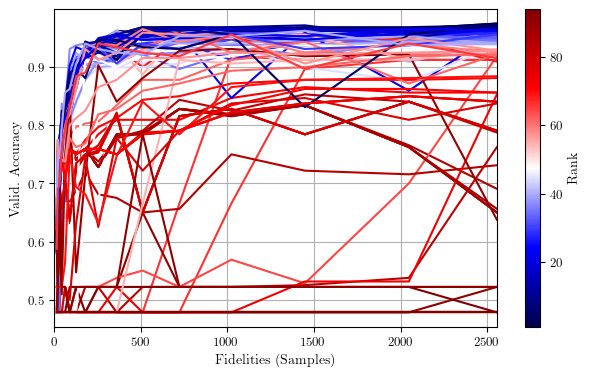

In [12]:
# Meaning of indexes
# fidelities, (train|valid|test), (accuracy|loss)

# Configuration of the plot
selected_split = "valid"
selected_score = "accuracy"

# Plotting
score_types = r_df["m:score_types"][0].tolist()
splits = ["train", "valid", "test"]
unit = r_df['m:fidelity_unit'][0]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure(figsize=figsize)

# corresponds to iloc indexing
scores_max_fidelity = r_df["m:score_values"].map(lambda x: x[-1, idx_split, idx_score]).to_numpy()
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()
for i in range(len(r_df)):
    fidelities = r_df.iloc[i]["m:fidelity_values"]
    scores = r_df.iloc[i]["m:score_values"][:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit.capitalize()})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()